# Drifter Simulations

***

In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from salishsea_tools import viz_tools

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Local functions

In [3]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix


def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()


def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)
    
    return pytime

***

### Load drifters and definitions

In [69]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201905',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'drifters': '/ocean/shared/drifters/data/L2/drifters_L2.mat',
    'out': '/data/bmoorema/results/parcels/drifters_base',
}

# Define Gaussian point cloud
n = 50   # number of particles
r = 10   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T

# Duration and timestep [s]
duration = timedelta(days=5)
dt = 90
       
# Load drifters
drifters = loadmat(paths['drifters'])['drifters'][0]

# Construct list of deployments inside SSC domain
IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if (drifters['lon'][dindex][0] < -125) and (drifters['lat'][dindex][0] < 49): IDout.append(ID)
    if mtime2datetime(float(drifters['mtime'][dindex][0])).year < 2016: IDout.append(ID)
    if ID > 300: IDout.append(ID)
for ID in IDout: IDs.remove(ID)

Group deployments by date and duration.

In [70]:
# Browse deployments
k = 0
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][t])) for t in [0, -1]]
    if (end - start).days >= 5:
        k += 1
        print(f'{k:02d}: {ID:03d},', start.strftime('%Y-%b-%d %H:%M,'), f'{(end-start).days:02} days')

01: 001, 2016-Apr-18 18:06, 14 days
02: 002, 2016-Apr-18 18:13, 05 days
03: 003, 2016-Apr-18 18:17, 06 days
04: 004, 2016-Apr-18 18:22, 10 days
05: 005, 2016-Apr-18 18:27, 08 days
06: 006, 2016-Apr-18 18:36, 11 days
07: 023, 2016-May-10 17:03, 05 days
08: 031, 2016-May-12 18:03, 10 days
09: 032, 2016-May-12 19:00, 06 days
10: 033, 2016-May-12 20:01, 08 days
11: 043, 2016-May-26 21:30, 05 days
12: 046, 2016-May-26 23:33, 11 days
13: 051, 2016-Jun-06 19:19, 12 days
14: 061, 2016-Jun-14 17:20, 09 days
15: 072, 2016-Jun-28 20:28, 11 days
16: 073, 2016-Jun-28 20:51, 14 days
17: 075, 2016-Jun-28 21:09, 09 days
18: 076, 2016-Jun-28 21:21, 12 days
19: 081, 2016-Jul-19 17:06, 11 days
20: 082, 2016-Jul-19 17:10, 10 days
21: 083, 2016-Jul-19 20:25, 09 days
22: 086, 2016-Jul-19 21:51, 05 days
23: 092, 2016-Aug-30 16:18, 13 days
24: 094, 2016-Aug-30 19:51, 09 days
25: 095, 2016-Aug-30 21:20, 15 days
26: 096, 2016-Aug-30 17:17, 21 days
27: 101, 2017-Feb-14 20:11, 14 days
28: 102, 2017-Feb-14 20:12, 

***

### Simulations

In [6]:
# Loop through drifters
for ID in IDs:
    
    # Create index and date identifiers for drifter ID
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][i])) for i in [0, -1]]
    
    # If the drifter was reporting at sea for at least 5 days, proceed
    if (end - start).days >= 5:

        # Define run paths
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
        outfile = os.path.join(paths['out'], fn)

        # Build filenames
        Ulist, Vlist = [], []
        for day in range(duration.days + 3):
            path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
            Ulist.append(path_NEMO + '_grid_U.nc')
            Vlist.append(path_NEMO + '_grid_V.nc')

        # Load NEMO forcing
        filenames = {
            'U': {'lon': paths['coords'], 'lat': paths['coords'], 'data': Ulist},
            'V': {'lon': paths['coords'], 'lat': paths['coords'], 'data': Vlist},
        }
        variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
        dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        field_set = FieldSet.from_nemo(filenames, variables, dimensions)

        # Execute run
        lon, lat = drifters['lon'][dindex][0] + x_offset, drifters['lat'][dindex][0] + y_offset
        pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, time=start)
        pset.execute(
            pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
        )

         It will be opened with no decoding. Filling values might be wrongly parsed.
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/c91ae0eb730ac165ed3dbbf8c45cd3be_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-TJZWMGNT.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-TJZWMGNT" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:20 Time:  0:01:20
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/9fb977696b338357904ac8bb72761bfe_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-PRGYOFGC.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-PRGYOFGC" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:05 Time:  0:01:05
INFO: Compiled JITParticleAdvec

100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:18 Time:  0:01:18
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/1ea27eb2569d9f24638f39f7fd3bb652_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-KBATAGKG.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-KBATAGKG" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:19 Time:  0:01:19
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/d6a73c3876fd945fbf91c3461f3cca84_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-MQPFOQKO.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-MQPFOQKO" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:16 Time:  0:01:16
INFO: Compiled JITParticleAdvectionR

INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-YOIRVMCQ" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:23 Time:  0:01:23
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/29e08cc45fe66448ddec2ad3aa1c2d8e_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-YLZEBBCE.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-YLZEBBCE" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:29 Time:  0:01:29
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/3351b99acfbcb385eb88d557e9b29410_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-GIFIUYQY.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-GIFIUYQY" to co

INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-UCWCXOWT" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:21 Time:  0:01:21
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/20c1bdc5e9358789641c422fa147e5ea_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-VNALUYYG.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-VNALUYYG" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:26 Time:  0:01:26
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/396ea0ee09a281b215401cdea36e7a29_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-BQPLGJLM.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-BQPLGJLM" to co

OSError: FieldSet file not found: /results/SalishSea/hindcast.201905/23jan18/SalishSea_1h_20180123_20180123_grid_U.nc

## Skill score comparisons

[Liu and Weisberg 2011, JGR Oceans](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JC006837)

$$\left. s = \sum_{i=1}^Nd_i \middle/ \sum_{i=1}^NI_{oi} \right.$$

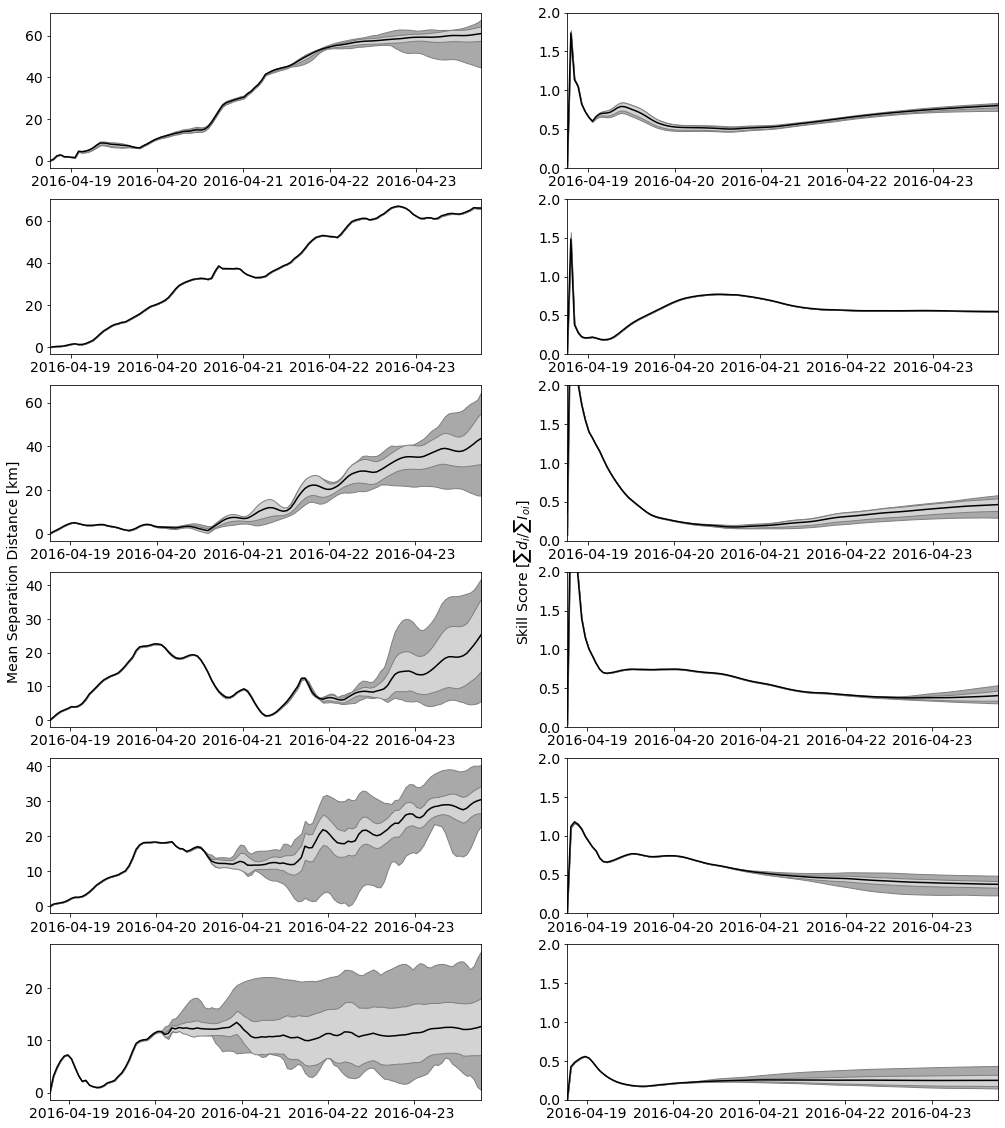

In [117]:
# Standard separation distance
fig, axs = plt.subplots(6, 2, figsize=(17, 20))
axs[3, 0].set_ylabel('Mean Separation Distance [km]', y=1)
axs[3, 1].set_ylabel('Skill Score [$\sum d_i/\sum I_{oi}$]', y=1)

for row, ID in zip(axs, range(1, 7)):
    row[1].set_ylim([0, 2])
    
    metrics = {
        'd': {'mean': np.empty(0), 'std': np.empty(0), 'min': np.empty(0), 'max': np.empty(0)},
        'dl': np.empty(0),
    }
    
    i = np.where(drifters['id'].astype(int) == ID)[0][0]
    start = mtime2datetime(float(drifters['mtime'][i][0]))
    fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
    outfile = os.path.join(paths['out'], fn)

    t_obs = np.array([mtime2datetime(float(d)) for d in drifters['mtime'][i]])
    index = 1
    with xr.open_dataset(outfile) as data:
        t_model = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
        for time, lon, lat in zip(t_model, data.lon.values.T, data.lat.values.T):
            ilast = index
            index = abs(t_obs - time).argmin()
            d = np.sqrt((lon - drifters['lon'][i][index])**2 + (lat - drifters['lat'][i][index])**2)*deg2m*1e-3
            dl = np.sqrt((drifters['lon'][i][index] - drifters['lon'][i][ilast])**2 + (drifters['lon'][i][index] - drifters['lon'][i][ilast])**2)*deg2m*1e-3
            metrics['dl'] = np.append(metrics['dl'], dl)
            for key in metrics['d']:
                metrics['d'][key] = np.append(metrics['d'][key], getattr(d, key)())

    row[0].fill_between(t_model, metrics['d']['min'], metrics['d']['max'], facecolor='darkgray', edgecolor='gray')
    row[0].fill_between(t_model, (metrics['d']['mean']+metrics['d']['std']), (metrics['d']['mean']-metrics['d']['std']), facecolor='lightgray', edgecolor='gray')
    row[0].plot(t_model, metrics['d']['mean'], 'k-')
    row[0].set_xlim([t_model[0], t_model[-1]])
    
    denom = np.cumsum(np.cumsum(metrics['dl']))
    row[1].fill_between(t_model, np.cumsum(metrics['d']['min'])/denom, np.cumsum(metrics['d']['max'])/denom, facecolor='darkgray', edgecolor='gray')
    row[1].fill_between(t_model, np.cumsum(metrics['d']['mean']+metrics['d']['std'])/denom, np.cumsum(metrics['d']['mean']-metrics['d']['std'])/denom, facecolor='lightgray', edgecolor='gray')
    row[1].plot(t_model, np.cumsum(metrics['d']['mean'])/denom, 'k-')
    
    for ax in row:
        ax.set_xlim([t_model[0], t_model[-1]])

#fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/sep_distance.pdf', bbox_inches='tight')

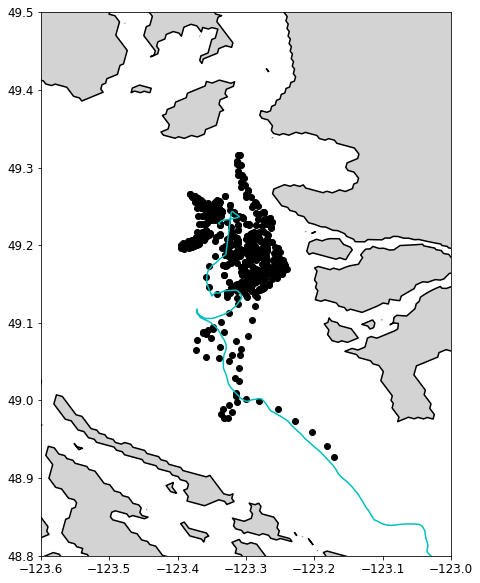

In [96]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-123.6, -123])
ax.set_ylim([48.8, 49.5])
viz_tools.set_aspect(ax)

with xr.open_dataset(outfile) as data:
    ax.plot(data.lon[:10, :], data.lat[:10, :], 'ko')
ax.plot(drifters['lon'][i], drifters['lat'][i], 'c-')

fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/drifter_sim.pdf', bbox_inches='tight')

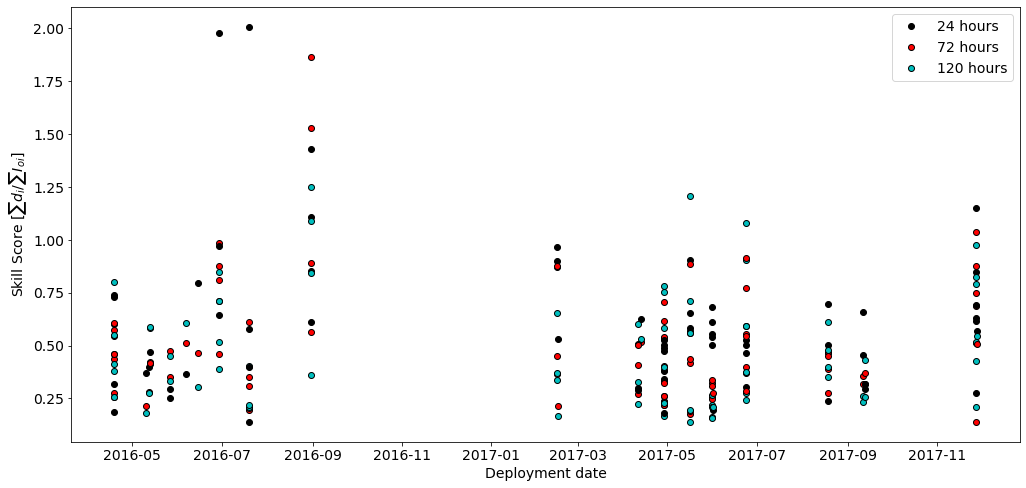

In [48]:
fig, ax = plt.subplots(figsize=(17, 8))
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][t])) for t in [0, -1]]
    if ((end - start).days >= 5) & (ID <= 207):
        
        metrics = {
            'd': {'mean': np.empty(0), 'std': np.empty(0), 'min': np.empty(0), 'max': np.empty(0)},
            'dl': np.empty(0),
        }
    
        dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
        start = mtime2datetime(float(drifters['mtime'][dindex][0]))
        time = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
        outfile = os.path.join(paths['out'], fn)

        t_obs = np.array([mtime2datetime(float(d)) for d in drifters['mtime'][dindex]])
        index = 1
        with xr.open_dataset(outfile) as data:
            t_model = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
            for time, lon, lat in zip(t_model, data.lon.values.T, data.lat.values.T):
                ilast = index
                index = abs(t_obs - time).argmin()
                d = np.sqrt((lon - drifters['lon'][dindex][index])**2 + (lat - drifters['lat'][dindex][index])**2)*deg2m*1e-3
                dl = np.sqrt((drifters['lon'][dindex][index] - drifters['lon'][dindex][ilast])**2 + (drifters['lon'][dindex][index] - drifters['lon'][dindex][ilast])**2)*deg2m*1e-3
                metrics['dl'] = np.append(metrics['dl'], dl)
                for key in metrics['d']:
                    metrics['d'][key] = np.append(metrics['d'][key], getattr(d, key)())
        
        denom = np.cumsum(np.cumsum(metrics['dl']))
        for i, color in zip([24, 72, 120], ['k', 'r', 'c']):
            label = f'{i} hours' if ID == 1 else None
            ax.plot(start, (np.cumsum(metrics['d']['mean'])/denom)[i], 'ko', markerfacecolor=color, label=label)

ax.set_xlabel('Deployment date')
ax.set_ylabel('Skill Score [$\sum d_i/\sum I_{oi}$]')
ax.legend()